In [5]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display


In [6]:
DATA_DIR = r"Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data"

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}

In [25]:
# Load datasets
import os

df_heart = pd.read_csv(os.path.join(DATA_DIR, DATASETS["heart_diagnoses_1"]))
df_labs = pd.read_csv(os.path.join(DATA_DIR, DATASETS["laboratory_events_codes_2"]))
df_micro = pd.read_csv(os.path.join(DATA_DIR, DATASETS["microbiology_events_codes_3"]))
df_procedure = pd.read_csv(os.path.join(DATA_DIR, DATASETS["procedure_code_4"]))

In [26]:
# ============================================================================
# DATA TYPE CONVERSION & STANDARDIZATION
# ============================================================================
print("="*80)
print("DATA TYPE CONVERSION & STANDARDIZATION")
print("="*80)

def convert_data_types(df, name):
    """
    Intelligently convert columns to appropriate data types
    """
    print(f"\n{name}:")
    print(f"  Original dtypes:\n{df.dtypes}\n")
    
    df_converted = df.copy()
    conversion_log = []
    
    for col in df_converted.columns:
        original_dtype = df_converted[col].dtype
        
        # Skip ID columns - keep as is
        if 'id' in col.lower():
            conversion_log.append(f"  {col}: {original_dtype} → {original_dtype} (ID column, kept as is)")
            continue
        
        # Try to convert object columns to numeric
        if df_converted[col].dtype == 'object':
            try:
                # Try numeric conversion
                converted = pd.to_numeric(df_converted[col], errors='coerce')
                
                # If more than 80% could be converted, convert
                non_null_orig = df_converted[col].notna().sum()
                non_null_conv = converted.notna().sum()
                conversion_rate = non_null_conv / non_null_orig if non_null_orig > 0 else 0
                
                if conversion_rate > 0.8:
                    df_converted[col] = converted
                    conversion_log.append(f"  {col}: object → float64 ({conversion_rate*100:.1f}% converted)")
                else:
                    conversion_log.append(f"  {col}: object → object (categorical, {conversion_rate*100:.1f}% convertible)")
            except:
                conversion_log.append(f"  {col}: object → object (categorical, non-numeric)")
        else:
            conversion_log.append(f"  {col}: {original_dtype} → {original_dtype} (already correct type)")
    
    for log_entry in conversion_log:
        print(log_entry)
    
    print(f"\n  Final dtypes:\n{df_converted.dtypes}\n")
    return df_converted

# Apply conversions to all datasets
df_heart = convert_data_types(df_heart, "Heart Diagnoses")
df_labs = convert_data_types(df_labs, "Labs")
df_micro = convert_data_types(df_micro, "Microbiology")
df_procedure = convert_data_types(df_procedure, "Procedures")

print("\n" + "="*80)
print("CONVERSION SUMMARY")
print("="*80)

for name, df in [("Heart Diagnoses", df_heart), ("Labs", df_labs), ("Microbiology", df_micro), ("Procedures", df_procedure)]:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"\n{name}:")
    print(f"  Numeric columns ({len(numeric_cols)}): {numeric_cols}")
    print(f"  Categorical columns ({len(object_cols)}): {object_cols}")

DATA TYPE CONVERSION & STANDARDIZATION

Heart Diagnoses:
  Original dtypes:
note_id             object
subject_id           int64
hadm_id              int64
note_type           object
note_seq             int64
charttime           object
storetime           object
HPI                 object
physical_exam       object
chief_complaint     object
invasions           object
X-ray               object
CT                  object
Ultrasound          object
CATH                object
ECG                 object
MRI                 object
reports             object
subject_id_dx        int64
icd_code            object
long_title          object
gender              object
age                float64
anchor_year        float64
dod                 object
dtype: object

  note_id: object → object (ID column, kept as is)
  subject_id: int64 → int64 (ID column, kept as is)
  hadm_id: int64 → int64 (ID column, kept as is)
  note_type: object → object (categorical, 0.0% convertible)
  note_seq: int64 → i

In [21]:
summary = pd.DataFrame({
    "Dataset": ["Heart Diagnoses", "Labs", "Microbiology", "Procedures"],
    "Rows": [len(df_heart), len(df_labs), len(df_micro), len(df_procedure)],
    "Columns": [len(df_heart.columns), len(df_labs.columns), len(df_micro.columns), len(df_procedure.columns)],
    "Keys": ["subject_id, hadm_id", "hadm_id", "subject_id, hadm_id", "subject_id, hadm_id"],
    "Content": [
        "ICD diagnoses",
        "Laboratory test results",
        "Microbiology tests",
        "Procedure codes"
    ]
})
summary

,Dataset,Rows,Columns,Keys,Content
0,Heart Diagnoses,4864,25,"subject_id, hadm_id",ICD diagnoses
1,Labs,978503,14,hadm_id,Laboratory test results
2,Microbiology,15587,14,"subject_id, hadm_id",Microbiology tests
3,Procedures,14497,6,"subject_id, hadm_id",Procedure codes


In [ ]:
def numeric_summary(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=["number"]).columns.tolist()
        cols = [c for c in cols if c not in ('subject_id', 'hadm_id')]
    out = []
    for c in cols:
        s = df[c]
        out.append({
            "variable": c,
            "min": s.min(),
            "max": s.max(),
            "mean": s.mean(),
            "std": s.std(),
            "missing_%": s.isna().mean() * 100
        })
    return pd.DataFrame(out)

num_stats = pd.concat(
    [
        numeric_summary(df_heart),
        numeric_summary(df_labs),
        numeric_summary(df_micro),
        numeric_summary(df_procedure)
    ],
    ignore_index=True
)

num_stats

,variable,min,max,mean,std,missing_%
0,subject_id,10000980.00,19998600.0,1.510717e+07,2.938761e+06,0.000000
1,hadm_id,20004456.00,29999670.0,2.501745e+07,2.873736e+06,0.000000
2,note_seq,2.00,94.0,1.469100e+01,8.260520e+00,0.000000
3,subject_id_dx,10000980.00,19998497.0,1.500158e+07,2.879841e+06,0.000000
4,age,18.00,95.0,6.897872e+01,1.497336e+01,71.977796
5,anchor_year,2110.00,2206.0,2.155621e+03,2.340010e+01,71.977796
6,hadm_id,20004456.00,29999670.0,2.504395e+07,2.868159e+06,0.000000
7,valuenum,-743.00,886449.0,6.733232e+01,2.175589e+03,7.274990
8,ref_range_lower,0.00,2200.0,3.172462e+01,4.484084e+01,11.544063
9,ref_range_upper,0.00,100000.0,5.579486e+01,4.005150e+02,11.544063


In [11]:
def quality_summary(df, name):
    return {
        "dataset": name,
        "missing_%": df.isna().mean().mean() * 100,
        "duplicates": df.duplicated().sum()
    }

dq = pd.DataFrame([
    quality_summary(df_heart, "Heart Diagnoses"),
    quality_summary(df_labs, "Labs"),
    quality_summary(df_micro, "Microbiology"),
    quality_summary(df_procedure, "Procedures")
])
dq

,dataset,missing_%,duplicates
0,Heart Diagnoses,12.329770,0
1,Labs,13.888592,2
2,Microbiology,29.491609,1
3,Procedures,0.000000,0


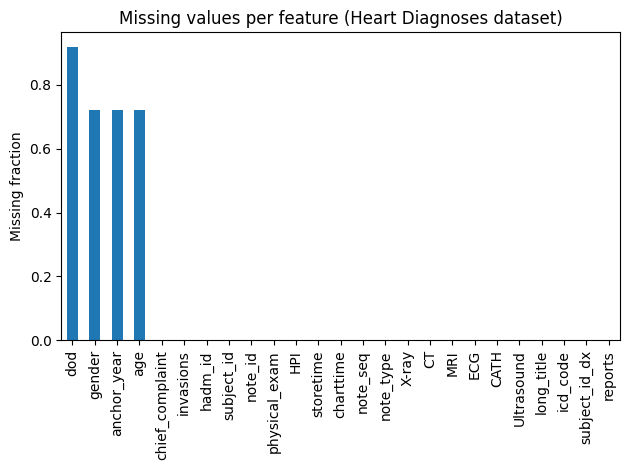

In [12]:
miss = df_heart.isna().mean().sort_values(ascending=False)

plt.figure()
miss.plot(kind="bar")
plt.ylabel("Missing fraction")
plt.title("Missing values per feature (Heart Diagnoses dataset)")
plt.tight_layout()
plt.show()


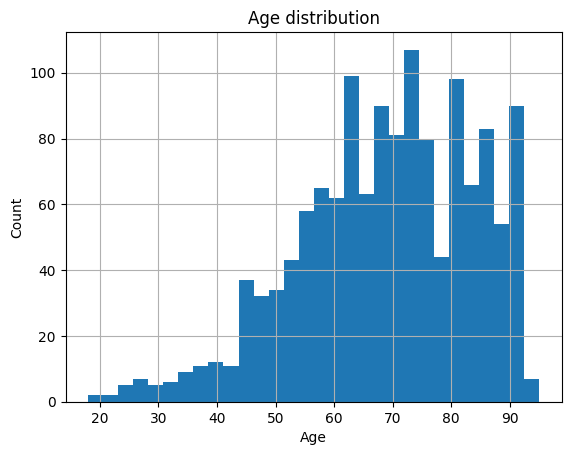

In [13]:
plt.figure()
df_heart["age"].dropna().hist(bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age distribution")
plt.show()


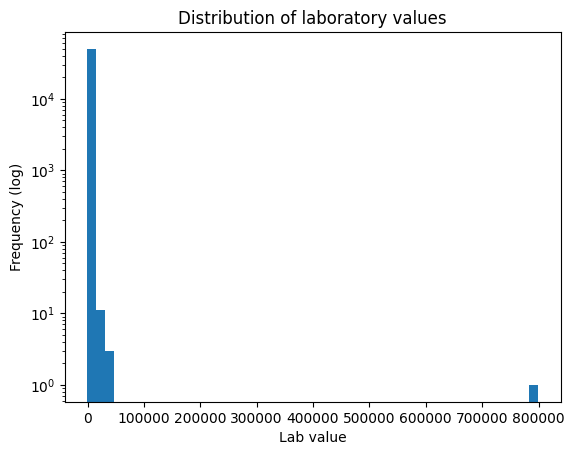

In [14]:
sample = df_labs["valuenum"].dropna().sample(50000, random_state=42)

plt.figure()
plt.hist(sample, bins=50)
plt.yscale("log")
plt.xlabel("Lab value")
plt.ylabel("Frequency (log)")
plt.title("Distribution of laboratory values")
plt.show()


In [15]:
labs_agg = (
    df_labs
    .groupby("hadm_id")["valuenum"]
    .agg(["mean", "std", "min", "max"])
    .reset_index()
)

adm = df_heart[["hadm_id", "age"]].drop_duplicates()
corr_df = adm.merge(labs_agg, on="hadm_id")


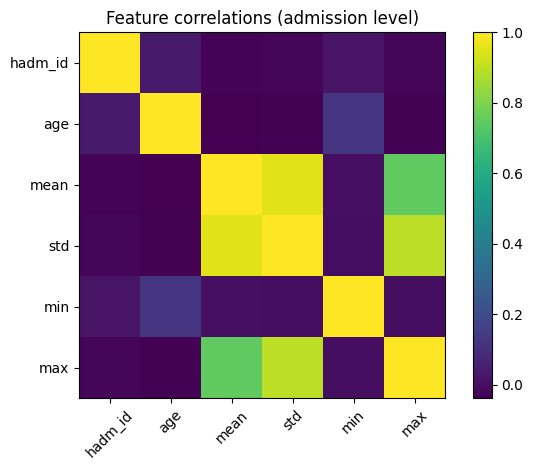

In [16]:
corr = corr_df.corr()

plt.figure()
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature correlations (admission level)")
plt.tight_layout()
plt.show()


1. DATASET OVERVIEW & STRUCTURE
        Dataset    Rows  Columns  Memory (MB)                                Primary Keys
Heart Diagnoses   4,864       25    30.466165 note_id, subject_id, hadm_id, subject_id_dx
           Labs 978,503       14   493.882599           hadm_id, fluid, analysis_batch_id
   Microbiology  15,587       14     8.880806          subject_id, hadm_id, technician_id
     Procedures  14,497        6     2.699800                         subject_id, hadm_id

Column Details:

Heart Diagnoses: ['note_id', 'subject_id', 'hadm_id', 'note_type', 'note_seq', 'charttime', 'storetime', 'HPI', 'physical_exam', 'chief_complaint', 'invasions', 'X-ray', 'CT', 'Ultrasound', 'CATH', 'ECG', 'MRI', 'reports', 'subject_id_dx', 'icd_code', 'long_title', 'gender', 'age', 'anchor_year', 'dod']

Labs: ['hadm_id', 'charttime', 'value', 'valuenum', 'valueuom', 'ref_range_lower', 'ref_range_upper', 'flag', 'label', 'fluid', 'examination_group', 'analysis_batch_id', 'qc_flag', 'ref_range']


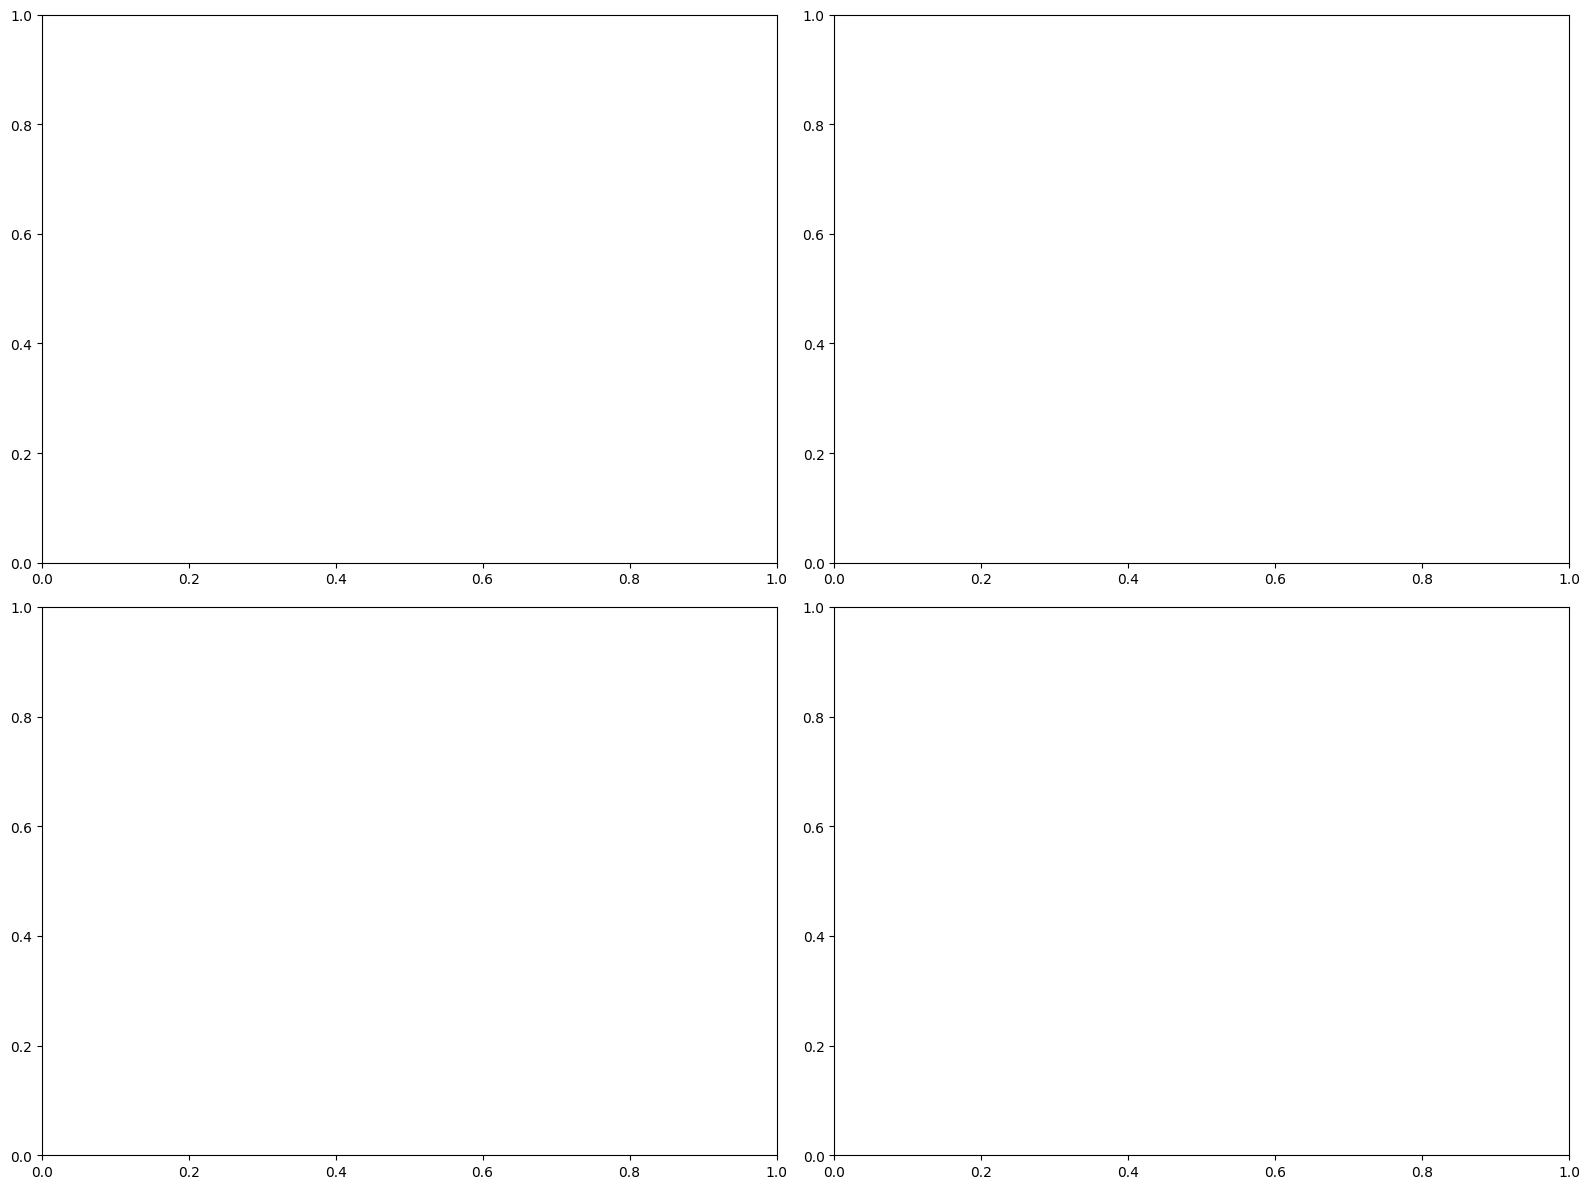


4. DISTRIBUTION PLOTS - NUMERICAL VARIABLES


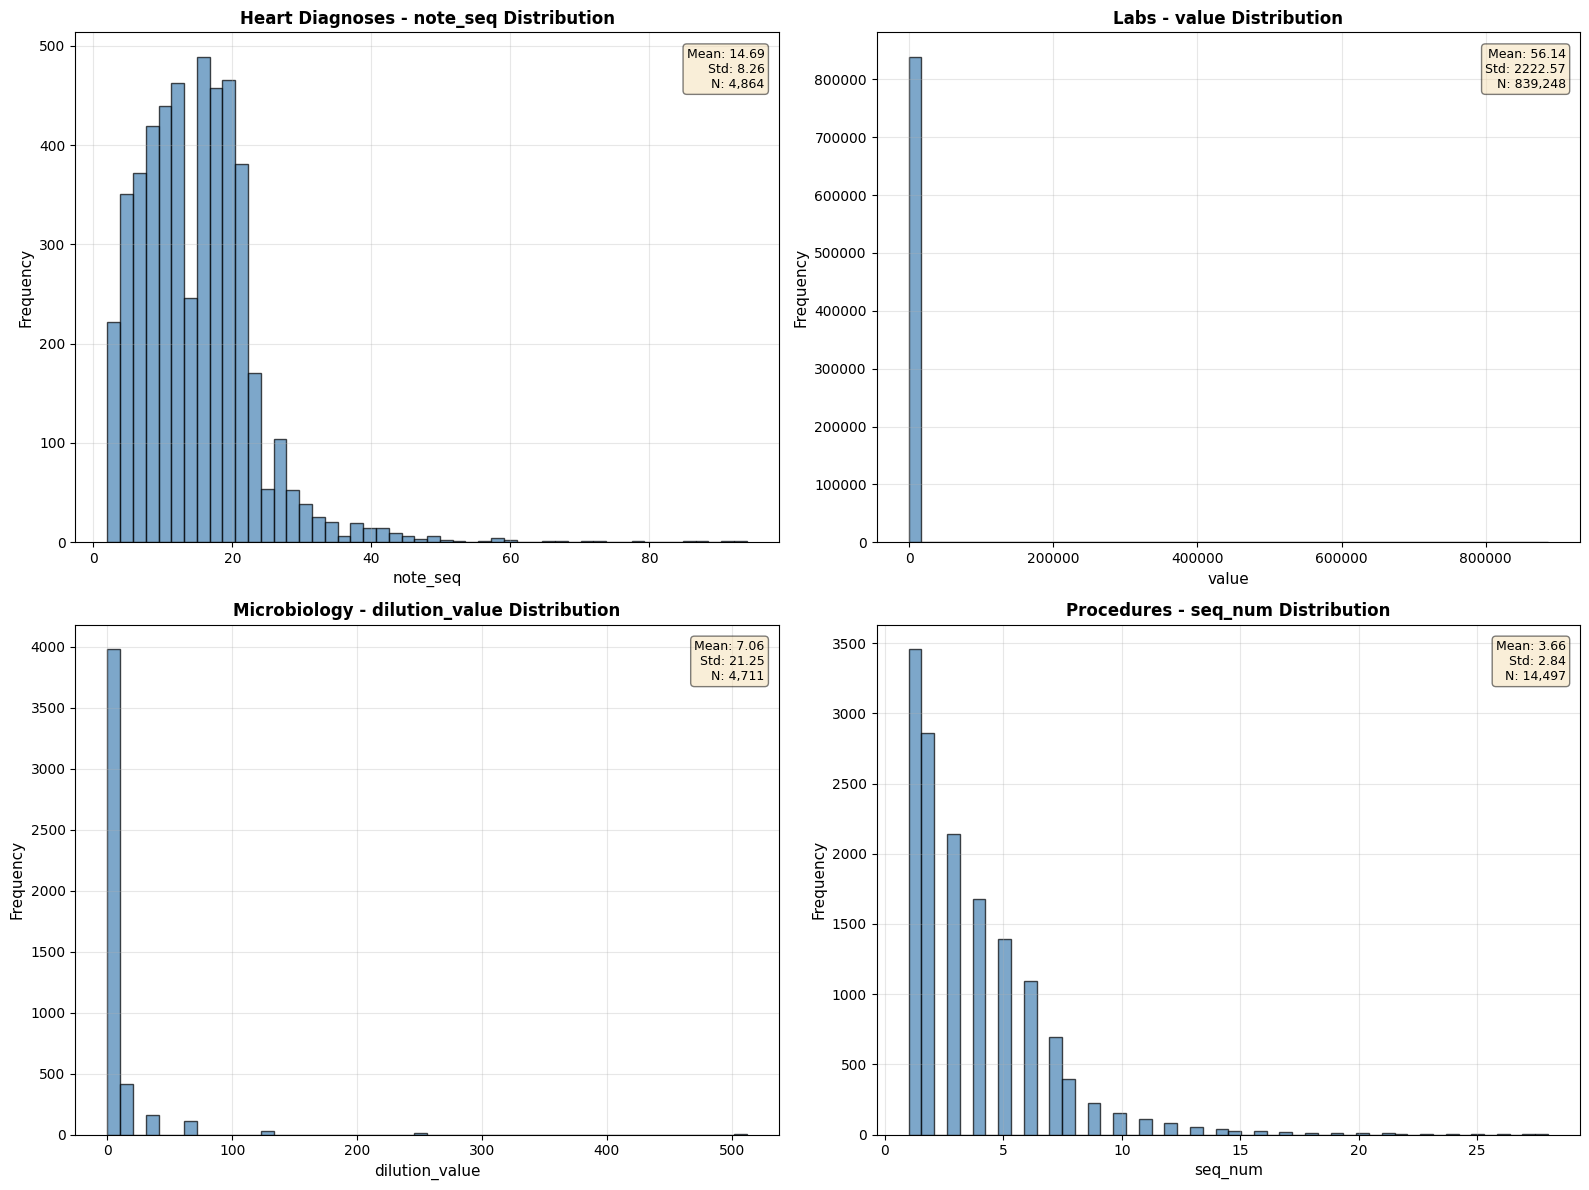


5. CATEGORICAL VARIABLES OVERVIEW

Heart Diagnoses:
  note_id: 4761 unique values
    Top 5: {'11673775-DS-19': np.int64(3), '13343289-DS-10': np.int64(3), '11984732-DS-17': np.int64(2), '11788649-DS-13': np.int64(2), '10305488-DS-7': np.int64(2)}
  note_type: 1 unique values
    Top 5: {'DS': np.int64(4864)}
  charttime: 4466 unique values
    Top 5: {'2185-01-11 03:00:00': np.int64(4), '2131-10-11 03:00:00': np.int64(4), '2196-03-28 03:00:00': np.int64(3), '2178-06-10 03:00:00': np.int64(3), '2187-04-13 03:00:00': np.int64(3)}
  storetime: 4761 unique values
    Top 5: {'2150-11-26 19:56:00': np.int64(3), '2126-05-03 17:53:00': np.int64(3), '2119-02-27 11:13:00': np.int64(2), '2182-09-08 21:59:00': np.int64(2), '2112-05-08 23:21:00': np.int64(2)}
  HPI: 4760 unique values
    Top 5: {":\n___ yo male with a PMH of asthma, htn, glaucoma who presents with \n30 min of chest pain which began 45 min ago. Resolved after one \nspray of nitroglycerin.\n\nHas had a respiratory illness for app

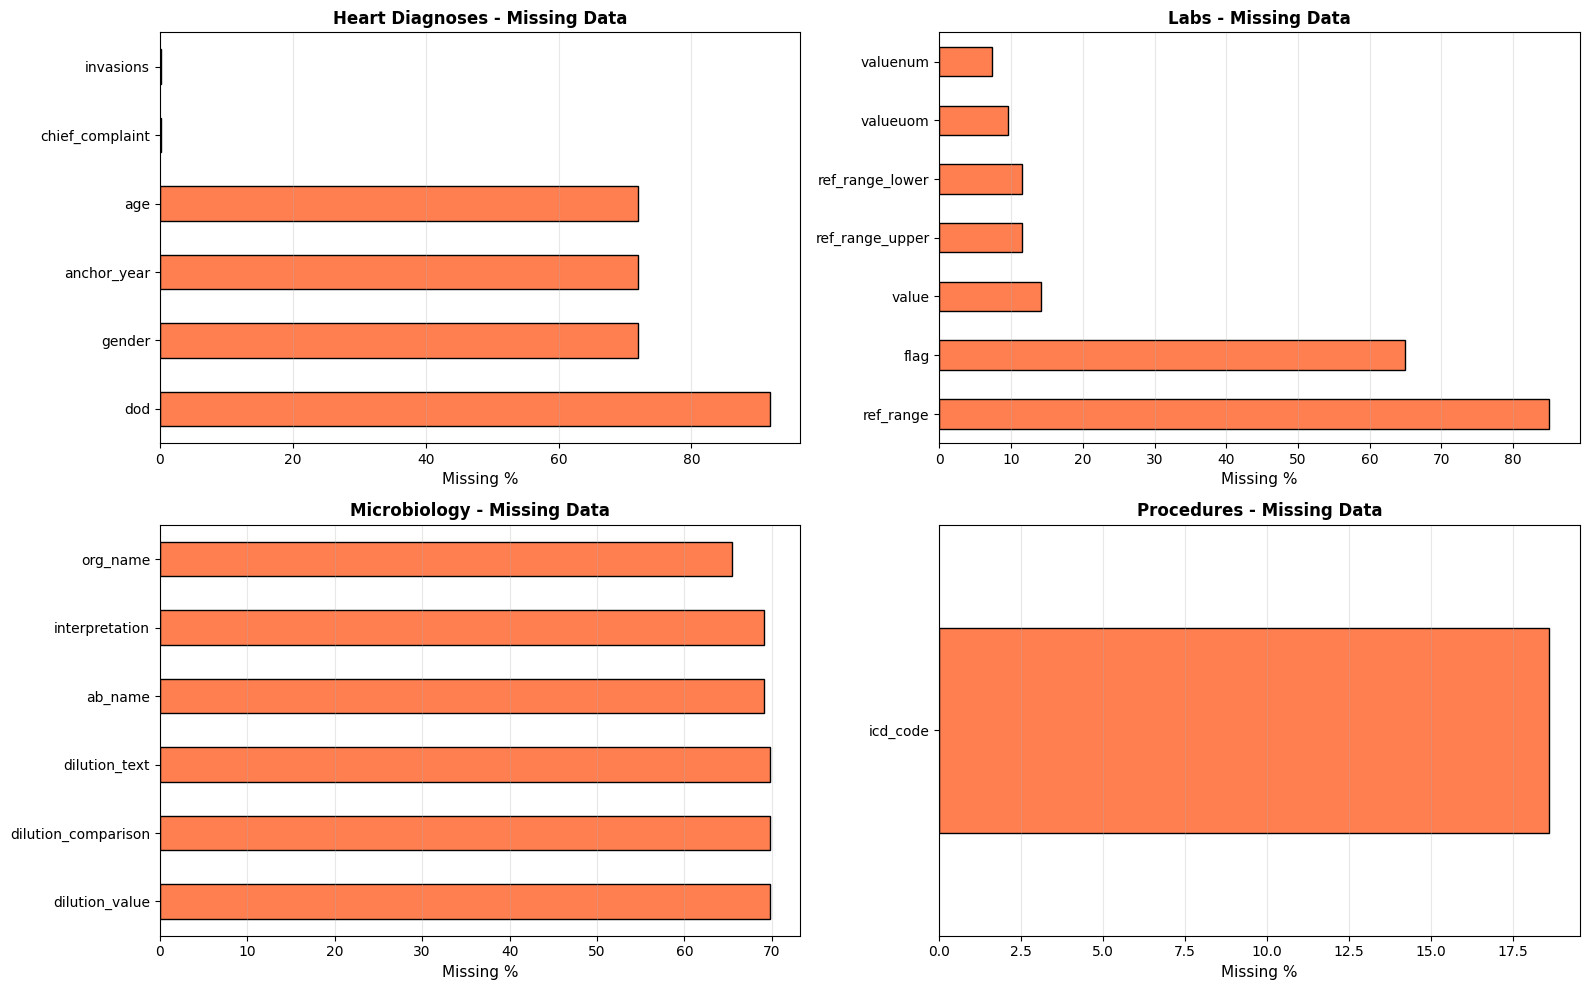


7. CROSS-DATASET INTEGRATION & LINKAGE ANALYSIS
                             Metric Value
Heart Diagnoses - Unique Admissions 4,761
           Labs - Unique Admissions 4,752
    Admissions in Both Heart & Labs 4,752
              Coverage (Labs/Heart) 99.8%
       Procedures - Unique Subjects 3,229
     Microbiology - Unique Subjects 2,616
Subjects in Both Procedures & Micro 1,876
        Coverage (Micro/Procedures) 58.1%

8. PAIRWISE CORRELATIONS AT ADMISSION LEVEL


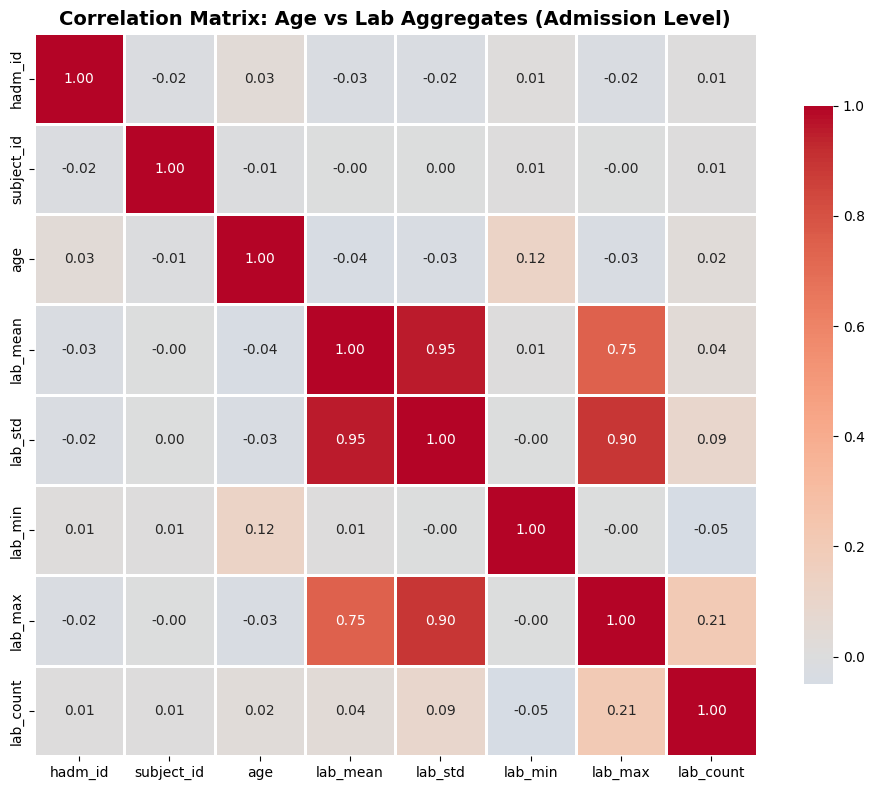


Top 10 Correlations with Age:
age           1.000000
lab_min       0.119352
hadm_id       0.034614
lab_count     0.024985
subject_id   -0.009012
lab_max      -0.031878
lab_std      -0.033432
lab_mean     -0.038483
Name: age, dtype: float64

9. DATA QUALITY SUMMARY & RECOMMENDATIONS

HEART DIAGNOSES DATASET:
✓ Comprehensive patient demographic and diagnosis data (ICD codes)
✓ Complete admission linkage
⚠ Age has 72.0% missing values - handle during preprocessing
→ Recommendation: Use mean/median imputation or age estimation from other sources

LABORATORY EVENTS DATASET:
✓ Large volume of test results (978,503 records)
✓ Good coverage with heart diagnoses (99.8% of admissions)
⚠ Value distribution is highly skewed - normalize before analysis
→ Recommendation: Aggregate to admission level for modeling; use log transformation

MICROBIOLOGY EVENTS DATASET:
✓ Specialized pathogen and test data
⚠ Sparse coverage - not all admissions have micro tests
→ Recommendation: Use as indicator (presen

In [27]:
# ============================================================================
# COMPREHENSIVE DATA UNDERSTANDING ANALYSIS
# ============================================================================

# 1. DATASET OVERVIEW & STRUCTURE
print("="*80)
print("1. DATASET OVERVIEW & STRUCTURE")
print("="*80)

datasets_info = {
    "Heart Diagnoses": df_heart,
    "Labs": df_labs,
    "Microbiology": df_micro,
    "Procedures": df_procedure
}

overview = []
for name, df in datasets_info.items():
    overview.append({
        "Dataset": name,
        "Rows": f"{len(df):,}",
        "Columns": len(df.columns),
        "Memory (MB)": df.memory_usage(deep=True).sum() / 1024**2,
        "Primary Keys": ", ".join([c for c in df.columns if 'id' in c.lower()])
    })

overview_df = pd.DataFrame(overview)
print(overview_df.to_string(index=False))
print("\nColumn Details:")
for name, df in datasets_info.items():
    print(f"\n{name}: {list(df.columns)}")

# ============================================================================
# 2. DATA QUALITY ASSESSMENT
# ============================================================================
print("\n" + "="*80)
print("2. DATA QUALITY ASSESSMENT")
print("="*80)

quality_metrics = []
for name, df in datasets_info.items():
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    quality_metrics.append({
        "Dataset": name,
        "Total Cells": df.shape[0] * df.shape[1],
        "Missing Values": df.isna().sum().sum(),
        "Missing %": f"{df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%",
        "Duplicates": df.duplicated().sum(),
        "Duplicate %": f"{df.duplicated().sum() / len(df) * 100:.2f}%",
        "Numeric Cols": len(numeric_cols)
    })

quality_df = pd.DataFrame(quality_metrics)
print(quality_df.to_string(index=False))

# Detailed missing data per column
print("\n\nMissing Data Per Column:")
for name, df in datasets_info.items():
    print(f"\n{name}:")
    missing = df.isna().sum().sort_values(ascending=False)
    missing = missing[missing > 0]
    if len(missing) > 0:
        for col, count in missing.items():
            pct = count / len(df) * 100
            print(f"  {col}: {count} ({pct:.1f}%)")
    else:
        print("  No missing values")

# ============================================================================
# 3. NUMERICAL VARIABLES DISTRIBUTION
# ============================================================================
print("\n" + "="*80)
print("3. NUMERICAL VARIABLES DISTRIBUTION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, df) in enumerate(datasets_info.items()):
    ax = axes[idx]
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['subject_id', 'hadm_id']]
    
    if numeric_cols:
        summary_table = []
        for col in numeric_cols:
            summary_table.append({
                "Variable": col,
                "Count": df[col].notna().sum(),
                "Mean": f"{df[col].mean():.4f}" if df[col].dtype in [np.float64] else "N/A",
                "Std": f"{df[col].std():.4f}" if df[col].dtype in [np.float64] else "N/A",
                "Min": f"{df[col].min():.4f}" if df[col].dtype in [np.float64] else df[col].min(),
                "25%": f"{df[col].quantile(0.25):.4f}" if df[col].dtype in [np.float64] else "N/A",
                "Median": f"{df[col].median():.4f}" if df[col].dtype in [np.float64] else "N/A",
                "75%": f"{df[col].quantile(0.75):.4f}" if df[col].dtype in [np.float64] else "N/A",
                "Max": f"{df[col].max():.4f}" if df[col].dtype in [np.float64] else df[col].max()
            })
        
        summary_table_df = pd.DataFrame(summary_table)
        print(f"\n{name}:")
        print(summary_table_df.to_string(index=False))

plt.tight_layout()
plt.savefig("../plots/1.1_du_numerical_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 4. DISTRIBUTION PLOTS FOR NUMERICAL VARIABLES
# ============================================================================
print("\n" + "="*80)
print("4. DISTRIBUTION PLOTS - NUMERICAL VARIABLES")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (name, df) in enumerate(datasets_info.items()):
    ax = axes[idx]
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['subject_id', 'hadm_id']]
    
    if numeric_cols and len(numeric_cols) > 0:
        # Plot first numeric column as example
        col = numeric_cols[0]
        data = df[col].dropna()
        
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
        ax.set_xlabel(col, fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'{name} - {col} Distribution', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        stats_text = f"Mean: {data.mean():.2f}\nStd: {data.std():.2f}\nN: {len(data):,}"
        ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, 
               verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)
    else:
        ax.text(0.5, 0.5, 'No numeric columns', ha='center', va='center')
        ax.set_title(name, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/1.1_du_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 5. CATEGORICAL VARIABLES OVERVIEW
# ============================================================================
print("\n" + "="*80)
print("5. CATEGORICAL VARIABLES OVERVIEW")
print("="*80)

for name, df in datasets_info.items():
    print(f"\n{name}:")
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    if cat_cols:
        for col in cat_cols:
            n_unique = df[col].nunique()
            top_values = df[col].value_counts().head(5)
            print(f"  {col}: {n_unique} unique values")
            print(f"    Top 5: {dict(top_values)}")
    else:
        print("  No categorical columns")

# ============================================================================
# 6. MISSING DATA VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("6. MISSING DATA VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, (name, df) in enumerate(datasets_info.items()):
    ax = axes[idx]
    missing_pct = (df.isna().sum() / len(df) * 100).sort_values(ascending=False)
    missing_pct = missing_pct[missing_pct > 0]
    
    if len(missing_pct) > 0:
        missing_pct.plot(kind='barh', ax=ax, color='coral', edgecolor='black')
        ax.set_xlabel('Missing %', fontsize=11)
        ax.set_title(f'{name} - Missing Data', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
    else:
        ax.text(0.5, 0.5, 'No missing values', ha='center', va='center', fontsize=12)
        ax.set_title(f'{name} - Missing Data', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("../plots/1.1_du_missing_data.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 7. CROSS-DATASET INTEGRATION & LINKAGE
# ============================================================================
print("\n" + "="*80)
print("7. CROSS-DATASET INTEGRATION & LINKAGE ANALYSIS")
print("="*80)

# Check overlap of admission IDs
heart_admissions = set(df_heart['hadm_id'].unique())
lab_admissions = set(df_labs['hadm_id'].unique())
micro_admissions = set(df_micro['hadm_id'].unique() if 'hadm_id' in df_micro.columns else [])
procedure_admissions = set(df_procedure['hadm_id'].unique() if 'hadm_id' in df_procedure.columns else [])

# Check overlap of subject IDs
heart_subjects = set(df_heart['subject_id'].unique())
micro_subjects = set(df_micro['subject_id'].unique() if 'subject_id' in df_micro.columns else [])
procedure_subjects = set(df_procedure['subject_id'].unique() if 'subject_id' in df_procedure.columns else [])

linkage_info = {
    "Metric": [
        "Heart Diagnoses - Unique Admissions",
        "Labs - Unique Admissions",
        "Admissions in Both Heart & Labs",
        "Coverage (Labs/Heart)",
        "Procedures - Unique Subjects",
        "Microbiology - Unique Subjects",
        "Subjects in Both Procedures & Micro",
        "Coverage (Micro/Procedures)"
    ],
    "Value": [
        f"{len(heart_admissions):,}",
        f"{len(lab_admissions):,}",
        f"{len(heart_admissions & lab_admissions):,}",
        f"{len(heart_admissions & lab_admissions) / len(heart_admissions) * 100:.1f}%",
        f"{len(procedure_subjects):,}",
        f"{len(micro_subjects):,}",
        f"{len(procedure_subjects & micro_subjects):,}",
        f"{len(procedure_subjects & micro_subjects) / len(procedure_subjects) * 100:.1f}%"
    ]
}

linkage_df = pd.DataFrame(linkage_info)
print(linkage_df.to_string(index=False))

# ============================================================================
# 8. PAIRWISE CORRELATIONS (AGGREGATED LEVEL)
# ============================================================================
print("\n" + "="*80)
print("8. PAIRWISE CORRELATIONS AT ADMISSION LEVEL")
print("="*80)

# Aggregate labs data
labs_agg = (
    df_labs
    .groupby("hadm_id")["valuenum"]
    .agg(["mean", "std", "min", "max", "count"])
    .reset_index()
    .rename(columns={
        'mean': 'lab_mean',
        'std': 'lab_std',
        'min': 'lab_min',
        'max': 'lab_max',
        'count': 'lab_count'
    })
)

# Merge with heart data (admission level)
adm_heart = df_heart[['hadm_id', 'subject_id', 'age']].drop_duplicates()
corr_df = adm_heart.merge(labs_agg, on='hadm_id', how='inner')

if len(corr_df) > 0:
    corr_matrix = corr_df.corr(numeric_only=True)
    
    # Visualize correlation matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title('Correlation Matrix: Age vs Lab Aggregates (Admission Level)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig("../plots/1.1_du_correlations.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Correlations with Age:")
    age_corr = corr_matrix['age'].sort_values(ascending=False)
    print(age_corr.head(10))

# ============================================================================
# 9. DATA QUALITY SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("9. DATA QUALITY SUMMARY & RECOMMENDATIONS")
print("="*80)

summary_report = """
HEART DIAGNOSES DATASET:
✓ Comprehensive patient demographic and diagnosis data (ICD codes)
✓ Complete admission linkage
⚠ Age has {:.1f}% missing values - handle during preprocessing
→ Recommendation: Use mean/median imputation or age estimation from other sources

LABORATORY EVENTS DATASET:
✓ Large volume of test results ({:,} records)
✓ Good coverage with heart diagnoses ({:.1f}% of admissions)
⚠ Value distribution is highly skewed - normalize before analysis
→ Recommendation: Aggregate to admission level for modeling; use log transformation

MICROBIOLOGY EVENTS DATASET:
✓ Specialized pathogen and test data
⚠ Sparse coverage - not all admissions have micro tests
→ Recommendation: Use as indicator (presence/absence) in features

PROCEDURES DATASET:
✓ Complete procedure code coverage
⚠ May need code mapping/aggregation for analysis
→ Recommendation: Aggregate by procedure type or frequency per admission

CROSS-DATASET INTEGRATION:
✓ Strong linkage possible via hadm_id (admission) and subject_id (patient)
✓ Time-series analysis potential with multiple events per admission
→ Recommendation: Build aggregate features at admission level for clustering/modeling
""".format(
    df_heart['age'].isna().sum() / len(df_heart) * 100,
    len(df_labs),
    len(heart_admissions & lab_admissions) / len(heart_admissions) * 100
)

print(summary_report)

14. SPACE-OPTIMIZED VISUALIZATIONS FOR REPORT


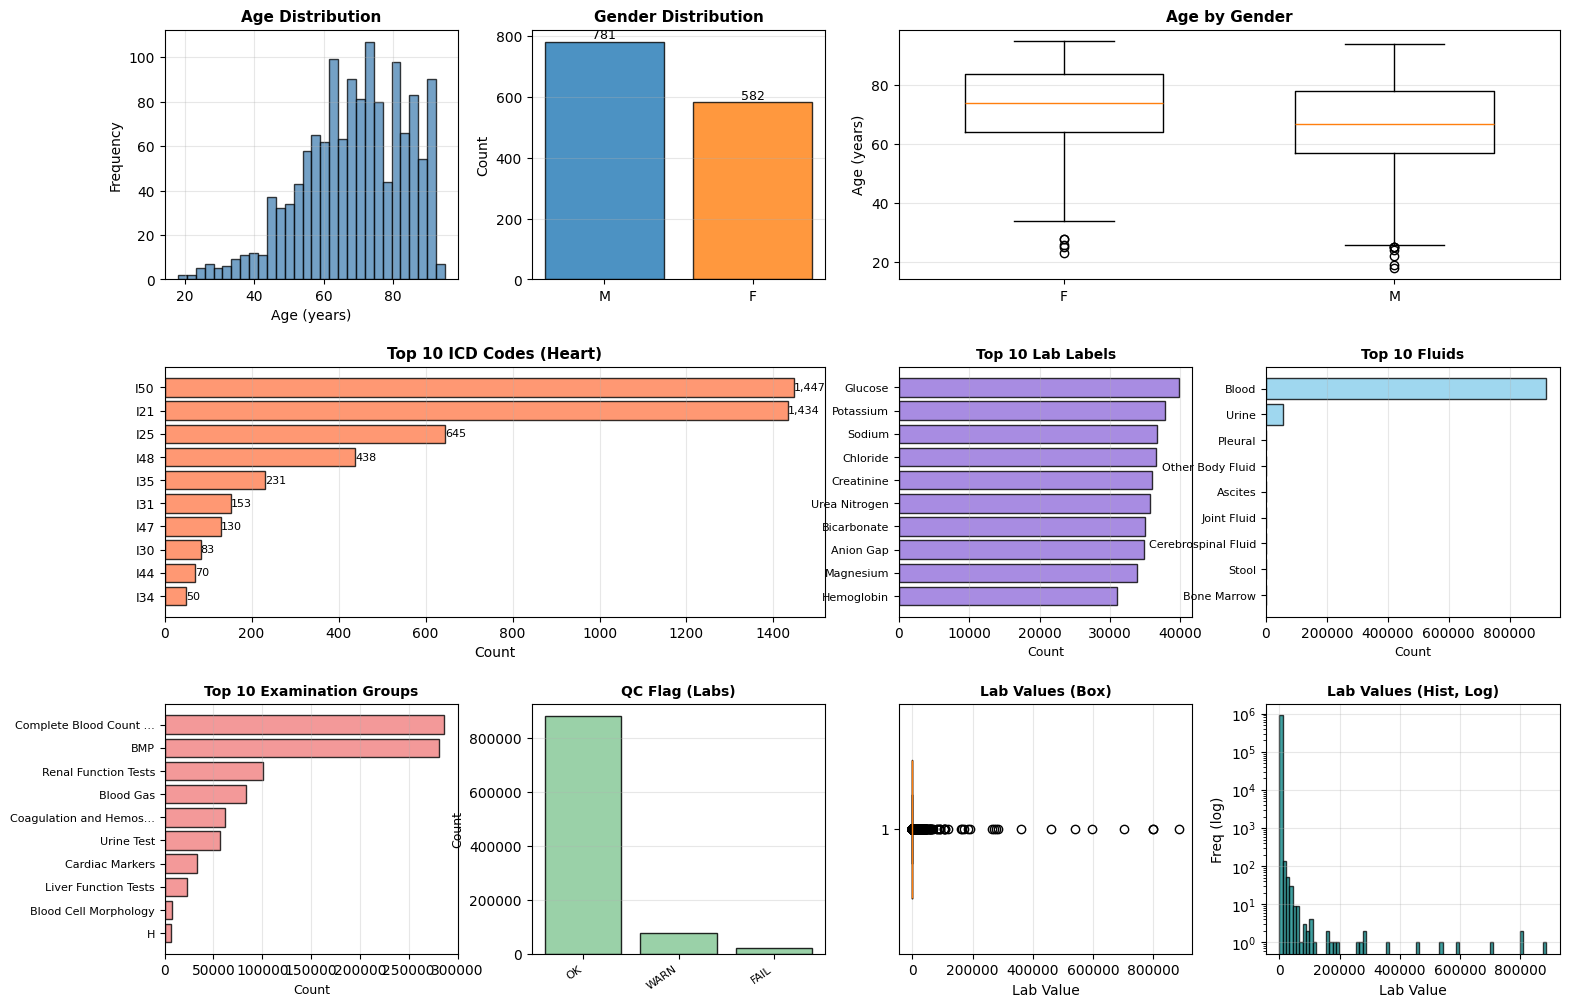

✓ DF1 & DF2 comprehensive visualization saved


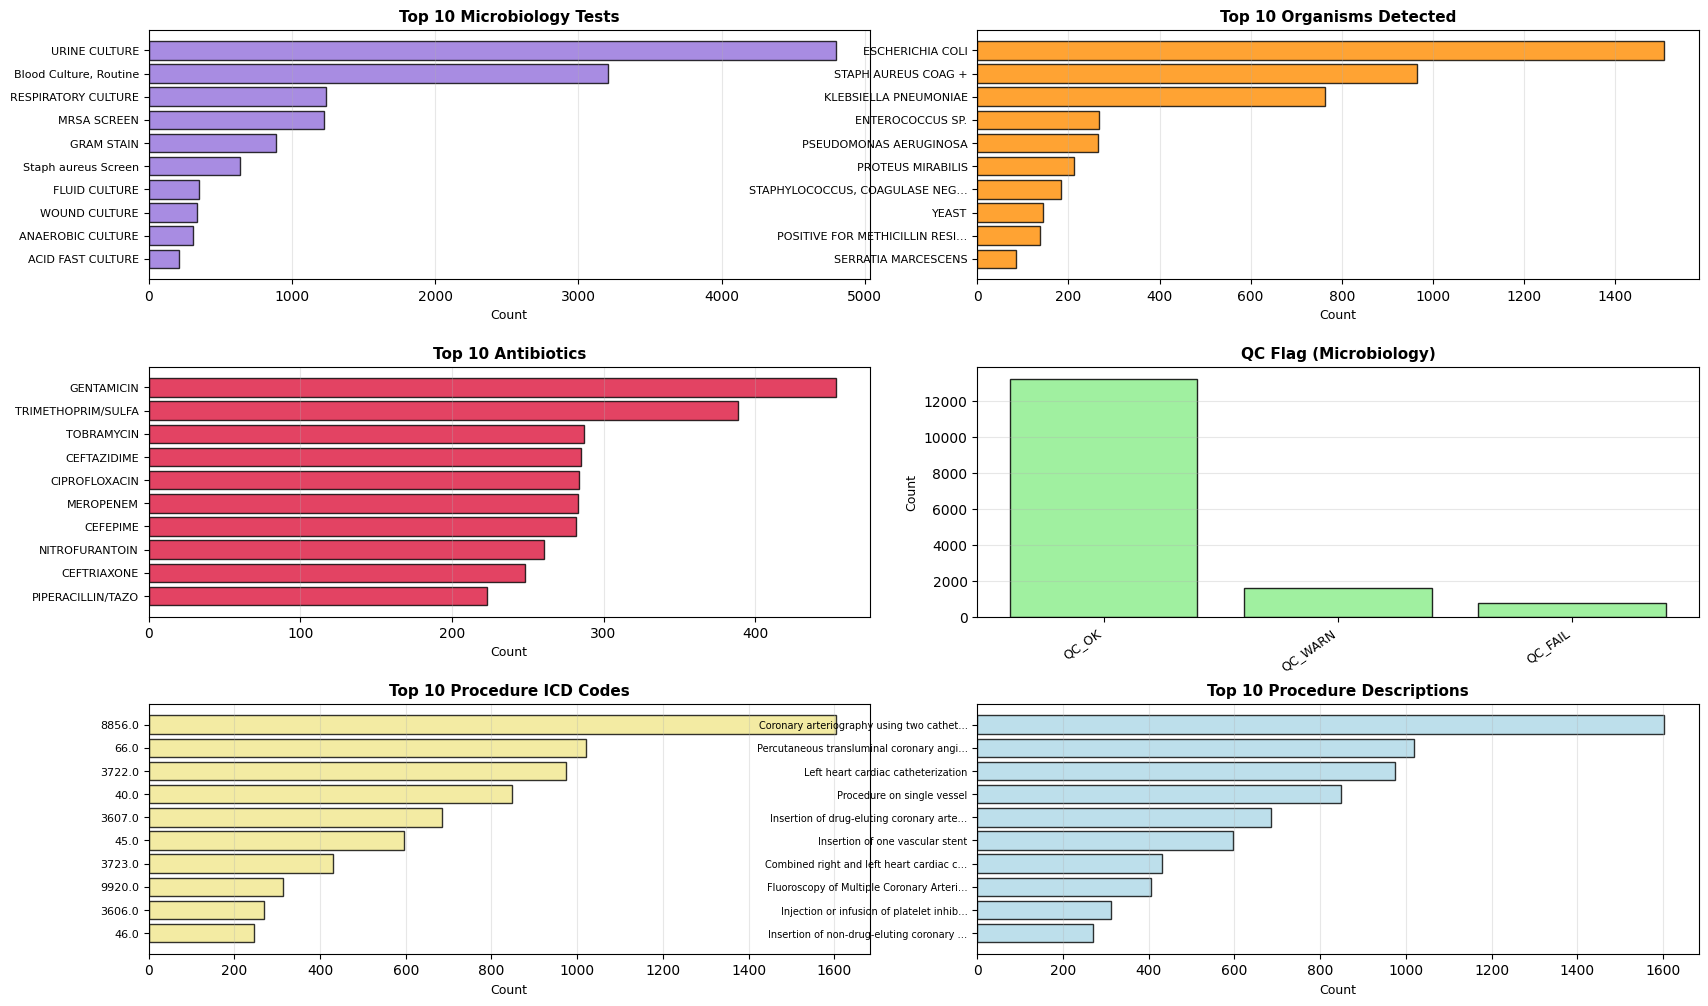

✓ DF3 & DF4 comprehensive visualization saved

DATA SUMMARY FOR REPORT
        Dataset  Records Age Range Gender Distribution Unique Codes/Tests      Key Metric
Heart Diagnoses     4864     18-95      M: 781, F: 582       20 ICD codes    Avg 69.0 yrs
           Labs   978503       N/A                 N/A      502 lab types   Value μ=67.33
   Microbiology    15587       N/A                 N/A           90 tests     QC flags: 3
     Procedures    14497       N/A                 N/A     305 procedures Subjects: 3,229

✓ All visualizations completed and saved to ../plots/


In [30]:
# ============================================================================
# 14. COMPREHENSIVE SPACE-OPTIMIZED VISUALIZATIONS FOR REPORT
# ============================================================================
print("="*80)
print("14. SPACE-OPTIMIZED VISUALIZATIONS FOR REPORT")
print("="*80)

# Helper to keep labels readable
truncate = lambda s, n=30: (str(s)[: n - 1] + "…") if len(str(s)) > n else str(s)

# Create a compact grid for DF1 + DF2 (9 plots)
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.35, wspace=0.25)

# ============================================================================
# DF1: HEART DIAGNOSES
# ============================================================================

# 1. Age distribution
ax1 = fig.add_subplot(gs[0, 0])
age_data = df_heart['age'].dropna()
ax1.hist(age_data, bins=30, color='steelblue', edgecolor='black', alpha=0.75)
ax1.set_xlabel('Age (years)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1.set_title('Age Distribution', fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Gender distribution
ax2 = fig.add_subplot(gs[0, 1])
gender_counts = df_heart['gender'].value_counts()
ax2.bar(gender_counts.index, gender_counts.values, color=['#1f77b4', '#ff7f0e'], edgecolor='black', alpha=0.8)
ax2.set_ylabel('Count', fontsize=10)
ax2.set_title('Gender Distribution', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(gender_counts.values):
    ax2.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 3. Age by Gender (box plot)
ax3 = fig.add_subplot(gs[0, 2:])
heart_gender_age = df_heart[['age', 'gender']].dropna()
if not heart_gender_age.empty:
    genders = list(heart_gender_age['gender'].unique())
    box_data = [heart_gender_age[heart_gender_age['gender'] == g]['age'] for g in genders]
    ax3.boxplot(box_data, positions=range(len(genders)), widths=0.6)
    ax3.set_xticks(range(len(genders)))
    ax3.set_xticklabels(genders)
    ax3.set_ylabel('Age (years)', fontsize=10)
    ax3.set_title('Age by Gender', fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No age/gender data', ha='center', va='center')

# 4. Top 10 ICD Codes
ax4 = fig.add_subplot(gs[1, 0:2])
top_icd = df_heart['icd_code'].value_counts().head(10)
ax4.barh(range(len(top_icd)), top_icd.values, color='coral', edgecolor='black', alpha=0.8)
ax4.set_yticks(range(len(top_icd)))
ax4.set_yticklabels([truncate(code, 22) for code in top_icd.index], fontsize=9)
ax4.set_xlabel('Count', fontsize=10)
ax4.set_title('Top 10 ICD Codes (Heart)', fontsize=11, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(top_icd.values):
    ax4.text(v, i, f'{v:,}', va='center', ha='left', fontsize=8)

# ============================================================================
# DF2: LABORATORY EVENTS
# ============================================================================

# 5. Top 10 Labels
ax5 = fig.add_subplot(gs[1, 2])
top_label = df_labs['label'].value_counts().head(10)
ax5.barh(range(len(top_label)), top_label.values, color='mediumpurple', edgecolor='black', alpha=0.8)
ax5.set_yticks(range(len(top_label)))
ax5.set_yticklabels([truncate(label, 22) for label in top_label.index], fontsize=8)
ax5.set_xlabel('Count', fontsize=9)
ax5.set_title('Top 10 Lab Labels', fontsize=10, fontweight='bold')
ax5.invert_yaxis()
ax5.grid(True, alpha=0.3, axis='x')

# 6. Top 10 Fluids
ax6 = fig.add_subplot(gs[1, 3])
top_fluid = df_labs['fluid'].value_counts().head(10)
ax6.barh(range(len(top_fluid)), top_fluid.values, color='skyblue', edgecolor='black', alpha=0.8)
ax6.set_yticks(range(len(top_fluid)))
ax6.set_yticklabels([truncate(f, 22) for f in top_fluid.index], fontsize=8)
ax6.set_xlabel('Count', fontsize=9)
ax6.set_title('Top 10 Fluids', fontsize=10, fontweight='bold')
ax6.invert_yaxis()
ax6.grid(True, alpha=0.3, axis='x')

# 7. Top 10 Examination Groups (use examination_group column)
ax7 = fig.add_subplot(gs[2, 0])
if 'examination_group' in df_labs.columns:
    top_exam = df_labs['examination_group'].value_counts().head(10)
else:
    top_exam = df_labs.select_dtypes(include=['object']).iloc[:, 0].value_counts().head(10)
ax7.barh(range(len(top_exam)), top_exam.values, color='lightcoral', edgecolor='black', alpha=0.8)
ax7.set_yticks(range(len(top_exam)))
ax7.set_yticklabels([truncate(e, 22) for e in top_exam.index], fontsize=8)
ax7.set_xlabel('Count', fontsize=9)
ax7.set_title('Top 10 Examination Groups', fontsize=10, fontweight='bold')
ax7.invert_yaxis()
ax7.grid(True, alpha=0.3, axis='x')

# 8. QC Flag distribution (Labs)
ax8 = fig.add_subplot(gs[2, 1])
if 'qc_flag' in df_labs.columns:
    qc_labs = df_labs['qc_flag'].fillna('NaN').value_counts()
    ax8.bar(range(len(qc_labs)), qc_labs.values, color='#88c999', edgecolor='black', alpha=0.85)
    ax8.set_xticks(range(len(qc_labs)))
    ax8.set_xticklabels([truncate(q, 18) for q in qc_labs.index], fontsize=8, rotation=35, ha='right')
    ax8.set_ylabel('Count', fontsize=9)
    ax8.set_title('QC Flag (Labs)', fontsize=10, fontweight='bold')
    ax8.grid(True, alpha=0.3, axis='y')
else:
    ax8.text(0.5, 0.5, 'No qc_flag column', ha='center', va='center')

# 9. Lab valuenum distribution (box plot)
ax9 = fig.add_subplot(gs[2, 2])
valuenum = df_labs['valuenum'].dropna()
ax9.boxplot([valuenum], vert=False, widths=0.55)
ax9.set_xlabel('Lab Value', fontsize=10)
ax9.set_title('Lab Values (Box)', fontsize=10, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')

# 10. Lab valuenum histogram (log scale)
ax10 = fig.add_subplot(gs[2, 3])
ax10.hist(valuenum, bins=80, color='teal', edgecolor='black', alpha=0.75)
ax10.set_yscale('log')
ax10.set_xlabel('Lab Value', fontsize=10)
ax10.set_ylabel('Freq (log)', fontsize=10)
ax10.set_title('Lab Values (Hist, Log)', fontsize=10, fontweight='bold')
ax10.grid(True, alpha=0.3)

plt.savefig("../plots/1.1_du_comprehensive_df1_df2.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ DF1 & DF2 comprehensive visualization saved")

# ============================================================================
# DF3 & DF4: MICROBIOLOGY & PROCEDURES
# ============================================================================

fig2 = plt.figure(figsize=(20, 12))
gs2 = fig2.add_gridspec(3, 4, hspace=0.35, wspace=0.35)

# DF3: Microbiology
# 1. Top 10 Test Names
ax1 = fig2.add_subplot(gs2[0, 0:2])
top_test = df_micro['test_name'].value_counts().head(10)
ax1.barh(range(len(top_test)), top_test.values, color='mediumpurple', edgecolor='black', alpha=0.8)
ax1.set_yticks(range(len(top_test)))
ax1.set_yticklabels([truncate(t, 30) for t in top_test.index], fontsize=8)
ax1.set_xlabel('Count', fontsize=9)
ax1.set_title('Top 10 Microbiology Tests', fontsize=11, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Top 10 Organisms
ax2 = fig2.add_subplot(gs2[0, 2:])
top_org = df_micro['org_name'].value_counts().head(10)
ax2.barh(range(len(top_org)), top_org.values, color='darkorange', edgecolor='black', alpha=0.8)
ax2.set_yticks(range(len(top_org)))
ax2.set_yticklabels([truncate(o, 30) for o in top_org.index], fontsize=8)
ax2.set_xlabel('Count', fontsize=9)
ax2.set_title('Top 10 Organisms Detected', fontsize=11, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3, axis='x')

# 3. Top 10 Antibiotics
ax3 = fig2.add_subplot(gs2[1, 0:2])
if 'ab_name' in df_micro.columns:
    top_ab = df_micro['ab_name'].value_counts().head(10)
    ax3.barh(range(len(top_ab)), top_ab.values, color='crimson', edgecolor='black', alpha=0.8)
    ax3.set_yticks(range(len(top_ab)))
    ax3.set_yticklabels([truncate(a, 30) for a in top_ab.index], fontsize=8)
    ax3.set_xlabel('Count', fontsize=9)
    ax3.set_title('Top 10 Antibiotics', fontsize=11, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3, axis='x')
else:
    ax3.text(0.5, 0.5, 'No antibiotics column', ha='center', va='center')

# 4. QC Flag distribution (Micro)
ax4 = fig2.add_subplot(gs2[1, 2:])
if 'qc_flag' in df_micro.columns:
    qc_micro = df_micro['qc_flag'].fillna('NaN').value_counts()
    ax4.bar(range(len(qc_micro)), qc_micro.values, color='lightgreen', edgecolor='black', alpha=0.85)
    ax4.set_xticks(range(len(qc_micro)))
    ax4.set_xticklabels([truncate(q, 18) for q in qc_micro.index], fontsize=9, rotation=35, ha='right')
    ax4.set_ylabel('Count', fontsize=9)
    ax4.set_title('QC Flag (Microbiology)', fontsize=11, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'No qc_flag column', ha='center', va='center')

# DF4: Procedures
# 5. Top 10 Procedure ICD Codes
ax5 = fig2.add_subplot(gs2[2, 0:2])
top_proc_icd = df_procedure['icd_code'].value_counts().head(10)
ax5.barh(range(len(top_proc_icd)), top_proc_icd.values, color='khaki', edgecolor='black', alpha=0.8)
ax5.set_yticks(range(len(top_proc_icd)))
ax5.set_yticklabels([truncate(p if not pd.isna(p) else 'NaN', 25) for p in top_proc_icd.index], fontsize=8)
ax5.set_xlabel('Count', fontsize=9)
ax5.set_title('Top 10 Procedure ICD Codes', fontsize=11, fontweight='bold')
ax5.invert_yaxis()
ax5.grid(True, alpha=0.3, axis='x')

# 6. Top 10 Procedure Descriptions
ax6 = fig2.add_subplot(gs2[2, 2:])
if 'long_title' in df_procedure.columns:
    top_proc_title = df_procedure['long_title'].value_counts().head(10)
    ax6.barh(range(len(top_proc_title)), top_proc_title.values, color='lightblue', edgecolor='black', alpha=0.8)
    ax6.set_yticks(range(len(top_proc_title)))
    ax6.set_yticklabels([truncate(t, 40) for t in top_proc_title.index], fontsize=7)
    ax6.set_xlabel('Count', fontsize=9)
    ax6.set_title('Top 10 Procedure Descriptions', fontsize=11, fontweight='bold')
    ax6.invert_yaxis()
    ax6.grid(True, alpha=0.3, axis='x')
else:
    ax6.text(0.5, 0.5, 'No description column', ha='center', va='center')

plt.savefig("../plots/1.1_du_comprehensive_df3_df4.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ DF3 & DF4 comprehensive visualization saved")

# ============================================================================
# SUMMARY STATISTICS TABLE
# ============================================================================
print("\n" + "="*80)
print("DATA SUMMARY FOR REPORT")
print("="*80)

summary_stats = {
    "Dataset": ["Heart Diagnoses", "Labs", "Microbiology", "Procedures"],
    "Records": [len(df_heart), len(df_labs), len(df_micro), len(df_procedure)],
    "Age Range": [
        f"{df_heart['age'].min():.0f}-{df_heart['age'].max():.0f}",
        "N/A",
        "N/A",
        "N/A"
    ],
    "Gender Distribution": [
        f"M: {(df_heart['gender']=='M').sum()}, F: {(df_heart['gender']=='F').sum()}",
        "N/A",
        "N/A",
        "N/A"
    ],
    "Unique Codes/Tests": [
        f"{df_heart['icd_code'].nunique()} ICD codes",
        f"{df_labs['label'].nunique()} lab types",
        f"{df_micro['test_name'].nunique()} tests",
        f"{df_procedure['icd_code'].nunique()} procedures"
    ],
    "Key Metric": [
        f"Avg {df_heart['age'].mean():.1f} yrs",
        f"Value μ={df_labs['valuenum'].mean():.2f}",
        f"QC flags: {df_micro['qc_flag'].nunique() if 'qc_flag' in df_micro.columns else 'N/A'}",
        f"Subjects: {df_procedure['subject_id'].nunique():,}"
    ]
}

summary_table = pd.DataFrame(summary_stats)
print(summary_table.to_string(index=False))
print("\n✓ All visualizations completed and saved to ../plots/")


In [ ]:
# Missingness and basic stats per column across all datasets
missing_rows = []
for ds_name, df in [
    ("Heart", df_heart),
    ("Labs", df_labs),
    ("Microbiology", df_micro),
    ("Procedures", df_procedure),
]:
    for col in df.columns:
        series = df[col]
        pct = series.isna().mean() * 100
        is_num = pd.api.types.is_numeric_dtype(series)
        num_series = pd.to_numeric(series, errors='coerce') if is_num else pd.Series(dtype=float)
        stats = {
            "Min": num_series.min() if not num_series.dropna().empty else np.nan,
            "Max": num_series.max() if not num_series.dropna().empty else np.nan,
            "Mean": series.mean() if is_num else np.nan,
            "Std": series.std() if is_num else np.nan,
        }
        missing_rows.append({
            "Dataset": ds_name,
            "Column": col,
            "Missing_%": round(pct, 2),
            "Missing_Count": int(series.isna().sum()),
            "Rows": len(df),
            "Min": stats["Min"],
            "Max": stats["Max"],
            "Mean": stats["Mean"],
            "Std": stats["Std"],
        })

missing_table = pd.DataFrame(missing_rows)
missing_table = missing_table.sort_values(["Missing_%", "Dataset", "Column"], ascending=[False, True, True]).reset_index(drop=True)
missing_table

,Dataset,Column,Missing_%,Missing_Count,Rows,Min,Max,Mean,Std
0,Heart Diagnoses,dod,91.82,4466,4864,NaN,NaN,NaN,NaN
1,Labs,ref_range,85.06,832288,978503,NaN,NaN,NaN,NaN
2,Heart Diagnoses,age,71.98,3501,4864,18.00,95.0,6.897872e+01,1.497336e+01
3,Heart Diagnoses,anchor_year,71.98,3501,4864,2110.00,2206.0,2.155621e+03,2.340010e+01
4,Heart Diagnoses,gender,71.98,3501,4864,NaN,NaN,NaN,NaN
5,Microbiology,dilution_comparison,69.78,10876,15587,NaN,NaN,NaN,NaN
6,Microbiology,dilution_value,69.78,10876,15587,0.06,512.0,7.062420e+00,2.124530e+01
7,Microbiology,dilution_text,69.76,10874,15587,NaN,NaN,NaN,NaN
8,Microbiology,ab_name,69.08,10767,15587,NaN,NaN,NaN,NaN
9,Microbiology,interpretation,69.08,10767,15587,NaN,NaN,NaN,NaN


In [ ]:
# Semantic stats table (only rows with complete stats, keep stats, drop missing cols)
stats_cols = ["Min", "Max", "Mean", "Std"]
semantics_table = missing_table.dropna(subset=stats_cols, how='any').copy()

formatted_table = semantics_table.copy()
formatted_table = formatted_table.drop(columns=["Missing_%", "Missing_Count"], errors="ignore")
formatted_table

,Dataset,Column,Missing_%,Missing_Count
2,Heart Diagnoses,age,71.98,3501
3,Heart Diagnoses,anchor_year,71.98,3501
6,Microbiology,dilution_value,69.78,10876
12,Procedures,icd_code,18.62,2699
13,Labs,value,14.23,139255
14,Labs,ref_range_lower,11.54,112959
15,Labs,ref_range_upper,11.54,112959
17,Labs,valuenum,7.27,71186
28,Heart Diagnoses,hadm_id,0.00,0
32,Heart Diagnoses,note_seq,0.00,0


In [38]:
# Missingness > 0 only, drop stats/Rows and format missing
nonzero_missing = missing_table[missing_table["Missing_%"] > 0].copy()
nonzero_missing["Missing_%"] = nonzero_missing["Missing_%"].apply(lambda x: f"{x:.2f}")
nonzero_missing = nonzero_missing.drop(columns=["Min", "Max", "Mean", "Std", "Rows"], errors="ignore")

nonzero_missing

,Dataset,Column,Missing_%,Missing_Count
0,Heart Diagnoses,dod,91.82,4466
1,Labs,ref_range,85.06,832288
2,Heart Diagnoses,age,71.98,3501
3,Heart Diagnoses,anchor_year,71.98,3501
4,Heart Diagnoses,gender,71.98,3501
5,Microbiology,dilution_comparison,69.78,10876
6,Microbiology,dilution_value,69.78,10876
7,Microbiology,dilution_text,69.76,10874
8,Microbiology,ab_name,69.08,10767
9,Microbiology,interpretation,69.08,10767
